### 1. Importar librerías para abrir coordenadas en archivos de polígonos .shx y .shp:

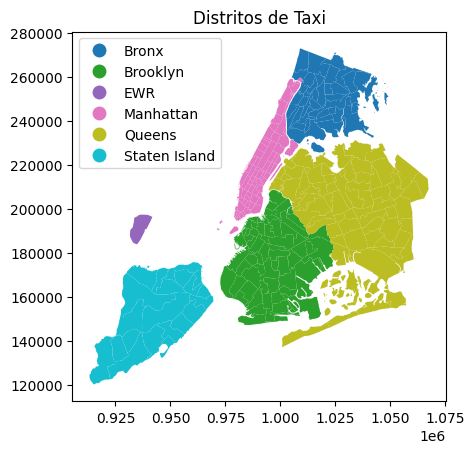

In [145]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar los datos geoespaciales
data = gpd.read_file('../Datasets/taxi_zones.shx')

# Visualizar los polígonos en un mapa, coloreando cada distrito con un color diferente y moviendo la leyenda a la parte superior
data.plot(column='borough', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Distritos de Taxi')
plt.show()



Se grafica correctamente los polígonos. A continuación se revisan los datos generados de los archivos:

In [146]:
data

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


### 2. Transformar coordenadas planas ATEST WELL-KNOWN IDENTIFIER 2263 a la proyección inversa mundial (EPSG:4326):

In [147]:
gdf = gpd.GeoDataFrame(data)

# Definir EPSG:2263 que está en pies (LATEST WELL-KNOWN IDENTIFIER 2263):
gdf.crs = 'EPSG:2263'

# Corregir coordenadas planas a mundiales:
gdf_latlon = gdf.to_crs('EPSG:4326')  # Proyección inversa al sistema de coordenadas geográficas

# Calcular los centroides de los polígonos
gdf_latlon['centroid'] = gdf_latlon['geometry'].centroid

# Extraer las coordenadas x e y de los centroides
gdf_latlon['centroid_x'] = gdf_latlon['centroid'].x
gdf_latlon['centroid_y'] = gdf_latlon['centroid'].y

# Mostrar el DataFrame con las coordenadas de los centroides
print(gdf_latlon[['centroid_x', 'centroid_y']])

     centroid_x  centroid_y
0    -74.174000   40.691831
1    -73.831299   40.616745
2    -73.847422   40.864474
3    -73.976968   40.723752
4    -74.188484   40.552659
..          ...         ...
258  -73.852215   40.897932
259  -73.906306   40.744235
260  -74.013023   40.709139
261  -73.946510   40.775932
262  -73.951010   40.778766

[263 rows x 2 columns]


C:\Users\davin\AppData\Local\Temp\ipykernel_27384\2524267641.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_latlon['centroid'] = gdf_latlon['geometry'].centroid


### 3. Ordenar y selecionar columnas:

In [148]:
# Seleccionar las columnas deseadas
gdf_latlon = gdf_latlon[['LocationID', 'borough', 'zone', 'centroid_x', 'centroid_y']]

# Renombrar las columnas centroid_x y centroid_y a longitud y latitud respectivamente
gdf_latlon = gdf_latlon.rename(columns={'centroid_x': 'longitud', 'centroid_y': 'latitud'})

Observar nuevos datos:

In [149]:
gdf_latlon

,LocationID,borough,zone,longitud,latitud
0,1,EWR,Newark Airport,-74.174000,40.691831
1,2,Queens,Jamaica Bay,-73.831299,40.616745
2,3,Bronx,Allerton/Pelham Gardens,-73.847422,40.864474
3,4,Manhattan,Alphabet City,-73.976968,40.723752
4,5,Staten Island,Arden Heights,-74.188484,40.552659
...,...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,-73.852215,40.897932
259,260,Queens,Woodside,-73.906306,40.744235
260,261,Manhattan,World Trade Center,-74.013023,40.709139
261,262,Manhattan,Yorkville East,-73.946510,40.775932


### 4. Importar a CSV df de mapa para cruzar con viajes y otros datasets:

In [150]:
import pandas as pd
gdf_latlon.to_csv('../DataClean/data_mapa.csv',index=False)